Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-29
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1808 rows, 1892 columns and 8864 nonzeros
Model fingerprint: 0x4f90f9e9
Variable types: 43 continuous, 1849 integer (1849 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [4e-02, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 1808 rows, 1891 columns, 8864 nonzeros
Variable types: 42 continuous, 1849 integer (1849 binary)
Found heuristic solution: objective 4100000.4205

Root relaxation: objective 8.236504e+00, 141 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0   

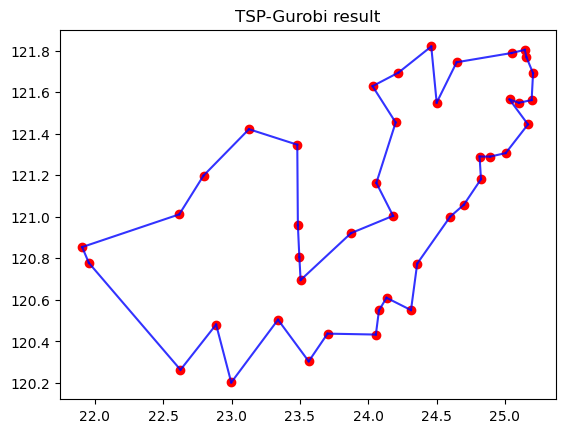

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
from gurobipy import *
import pandas as pd
# some paramters 
city_num = 43  # the number of citys
size = 50  # size
r1 = 0.7  # pbest-xi
r2 = 0.8  # gbest-xi
iter_num = 1000  # iteration
fitneess_value_list = []  # fitness Value
distance_matrix= np.zeros((city_num,city_num))
# here we read the data and record the data
excel_data_df = pd.read_excel('台灣景點經緯度.xlsx')
city_num = 43
Z = []
X = []
Y = []
for i in range(city_num):
    Z.append(excel_data_df['經緯度（十進位度數 (DD)）'][i])
    X.append(float(Z[i].split(', ')[0]))
    Y.append(float(Z[i].split(', ')[1]))

# the distance 
for i in range(0,city_num):
    for j in range(0,city_num):
        if (i==j):
            distance_matrix[i,j]=100000
        else:
            distance_matrix[i,j]=np.sqrt(np.square((X[i]-X[j]))+np.square((Y[i]-Y[j])))
def calculate_distance(X, Y):
    distance_matrix = np.zeros((city_num, city_num))
    for i in range(city_num):
        for j in range(city_num):
            if i == j:
                continue
            dis = np.sqrt((X[i] - X[j]) ** 2 + (Y[i] - Y[j]) ** 2)  # count the distance
            distance_matrix[i][j] = dis
    return distance_matrix

def get_children(lt_N):
    # get all subset
    n = len(lt_N)
    result = []
    for i in range(2 ** n):  # 子集个数，每循环一次一个子集
        combo = []
        for j in range(n):  # 用来判断二进制下标为j的位置数是否为1
            if(i >> j) % 2:
                combo.append(lt_N[j])
        result.append(combo)
    return result

V = [i for i in range(city_num)] #city sets
D = calculate_distance(X, Y)    #calculate the distance
D_ij = list(D)                  #change to the list

t_start = time.process_time()          #start record the time

md = Model('TSP_2')               #create the model

x_ij = md.addMVar((city_num,city_num),lb=0,ub=1,vtype=GRB.BINARY)    #create the variables
Makespan = md.addMVar((city_num),vtype=GRB.CONTINUOUS)

for i in range(0,city_num):  
    constrsum=sum(x_ij[i,:])
    md.addConstr(constrsum==1)

for j in range(0,city_num):  
    constrsum1=sum(x_ij[:,j])
    md.addConstr(constrsum1==1)

for i in range(1,city_num):  
    for j in range(1,city_num): 
        if(i!=j):
            md.addConstr((Makespan[i]-Makespan[j]+city_num*x_ij[i,j])<=city_num-1)

# here we record the obkective model
objsum=[]
for i in range(0,city_num):  
    for j in range(0,city_num):  
        objsum=objsum+x_ij[i,j]*distance_matrix[i,j]
md.setObjective(objsum,GRB.MINIMIZE)

md.optimize()   #optimize

t_finish = time.process_time() - t_start   #end of record the time

plt.scatter(X, Y, color='r')    #draw the points
result = []
for i in V:
    for j in V:
        if x_ij[i,j].x > 0:
            result.append((i,j))
            plt.plot([X[i],X[j]],[Y[i],Y[j]],color='b', alpha=0.8)  #draw the line

gbest = [0]
index = 0
gbest[0] = result[0][0]
for i in V[1:]:
    gbest.append(result[index][1])
    index = gbest[-1]   
print('The optimal result of Gurobis solution is: ', md.objVal)
print('The optimal variable for Gurobi is：', gbest)    #print the result
print('Gurobi takes time to solve: ', t_finish)
plt.title('TSP-Gurobi result') 

# show the plot
plt.show()